In [1]:
%pip install -U yt-dlp ffmpeg-python

Note: you may need to restart the kernel to use updated packages.


In [14]:
#import uuid
#from google.colab import auth
import pandas as pd
import numpy as np
import os, math
#from google.cloud import storage
#import torch
#import laion_clap

#from io import BytesIO
import io

import csv
import urllib.request
from ast import literal_eval

import sklearn

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import hamming_loss, precision_recall_fscore_support, average_precision_score
#from sklearn.neural_network import MLPClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import AdaBoostClassifier

#from sklearn.preprocessing import MultiLabelBinarizer
#from sklearn.decomposition import PCA

#import umap.umap_ as umap

#from scipy.cluster.hierarchy import dendrogram, linkage

#import heapq
#import typhon
import seaborn as sns
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
from matplotlib.patches import Rectangle

import seaborn as sns
import warnings

from tqdm.notebook import tqdm
import ffmpeg

import laion_clap
import pickle

from IPython.display import YouTubeVideo
from IPython.display import HTML

In [26]:
#ytid = "xQRhsoSCXvg"
#ytid = "YLt73w6criQ"
#ytid = "_qAJMXfL6o0"
#ytid = "5HgTgpqtwns"
#ytid = "XUERPM7NGN0" # "Easy First Drum Lesson - For Kids!"
#ytid = "lzUjZXdae8Q" # "Sounds in the Woods" {Drumming Song for Kids}"
ytid = "QNzuC9pdqcU" # "Cordless Drill Basics | Beginner"
yturl = f"https://www.youtube.com/watch?v={ytid}"

In [27]:
!yt-dlp -x -f "bestaudio" --audio-format mp3 --audio-quality 64k --force-keyframes-at-cuts --external-downloader ffmpeg $yturl -o "yt-samples/%(id)s.%(ext)s"

[youtube] Extracting URL: https://www.youtube.com/watch?v=QNzuC9pdqcU
[youtube] QNzuC9pdqcU: Downloading webpage
[youtube] QNzuC9pdqcU: Downloading ios player API JSON
[youtube] QNzuC9pdqcU: Downloading android player API JSON
[youtube] QNzuC9pdqcU: Downloading m3u8 information
[info] QNzuC9pdqcU: Downloading 1 format(s): 251
[download] yt-samples/QNzuC9pdqcU.mp3 has already been downloaded
[ExtractAudio] Not converting audio yt-samples/QNzuC9pdqcU.mp3; file is already in target format mp3


In [28]:
if not os.path.isfile('music_speech_audioset_epoch_15_esc_89.98.pt'):
    !wget https://huggingface.co/lukewys/laion_clap/resolve/main/music_speech_audioset_epoch_15_esc_89.98.pt
clap_model = laion_clap.CLAP_Module(enable_fusion=False, amodel='HTSAT-base')
clap_model.load_ckpt('music_speech_audioset_epoch_15_esc_89.98.pt')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Load the specified checkpoint music_speech_audioset_epoch_15_esc_89.98.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.

In [29]:
input_file = f'yt-samples/{ytid}.mp3'
duration = float(ffmpeg.probe(input_file)["format"]["duration"])
duration_for_embed = 10

embeddings = list()
for start in range(0, int(duration), duration_for_embed):
    stop = start + duration_for_embed
    output_file = f'yt-samples/temp.mp3'
    !ffmpeg -i $input_file -ss $start -t $duration_for_embed -acodec copy $output_file -y -loglevel error
    audio_embed = np.squeeze(clap_model.get_audio_embedding_from_filelist(x=[output_file], use_tensor=False))
    embeddings.append(audio_embed)

np_embeddings = np.vstack(embeddings)

In [30]:
with open('export-clap-probe/clap-probe.pkl', 'rb') as f:
    multioutput_model = pickle.load(f)

dfmetrics = pd.read_csv("export-clap-probe/clap-probe.csv")
dfmetrics = dfmetrics.sort_values("model_order")
dfmetrics

,group_name,precision,recall,fscore,support,threshold,display_names,model_order
24,Emergency vehicle alarms and sirens,0.875000,0.798246,0.834862,228,0.50,"['Emergency vehicle', 'Police car (siren)', 'A...",0
0,General music,0.659532,0.930480,0.771920,4603,0.60,['Music'],1
49,Cat sounds,0.880000,0.633094,0.736402,139,0.50,"['Meow', 'Caterwaul', 'Cat', 'Purr']",2
55,Percussion instruments: steelpan and bagpipes,0.985294,0.603604,0.748603,111,0.50,"['Steelpan', 'Bagpipes']",3
34,"Farm animal sounds: chickens, turkeys, roosters",0.884298,0.581522,0.701639,184,0.50,"['Turkey', 'Gobble', 'Chicken, rooster', 'Crow...",4
...,...,...,...,...,...,...,...,...
5,"Electronic music genres: house, techno, dubstep",0.831683,0.174636,0.288660,481,0.65,"['Electronica', 'Trance music', 'Techno', 'Hou...",59
59,"Sports sounds: basketball bounces, slams",0.923077,0.242424,0.384000,99,0.50,"['Slam', 'Basketball bounce']",60
40,"Explosion sounds: firecrackers, fireworks",0.739130,0.303571,0.430380,168,0.55,"['Fireworks', 'Firecracker', 'Explosion', 'Bur...",61
36,"Vocal efforts: screaming, crying, sobbing",0.803279,0.270718,0.404959,181,0.50,"['Screaming', 'Wail, moan', 'Crying, sobbing',...",62


In [31]:
all_probs = multioutput_model.predict_proba(np_embeddings)
all_probs = np.squeeze(np.dstack(all_probs)[:,1,:])

In [32]:
#group_name_to_threshold = pd.Series(dfmetrics.threshold.values, index=dfmetrics.group_name).to_dict()
#group_name_to_model_order = pd.Series(dfmetrics.model_order.values, index=dfmetrics.group_name).to_dict()
model_order_to_group_name = pd.Series(dfmetrics.group_name.values, index=dfmetrics.model_order).to_dict()

In [33]:
all_preds = np.empty_like(all_probs, dtype=np.int8)
for _, row in dfmetrics.iterrows():
    order = row["model_order"]
    threshold = row["threshold"]
    all_preds[:, order] = (all_probs[:, order] >= threshold).astype(np.int8)

In [34]:
for time_i in range(all_preds.shape[0]):
    detections = np.where(all_preds[time_i, :])[0]
    groups_detected = [model_order_to_group_name[x] for x in detections]
    start_time = time_i * duration_for_embed
    stop_time = start_time + duration_for_embed 
    print(f"{start_time}-{stop_time}s: detected {groups_detected}")

0-10s: detected []
10-20s: detected ['Human speech']
20-30s: detected []
30-40s: detected ['Human speech']
40-50s: detected []
50-60s: detected []
60-70s: detected ['General music', 'Human speech']
70-80s: detected ['Human speech']
80-90s: detected ['Human speech']
90-100s: detected ['Human speech']
100-110s: detected []
110-120s: detected []
120-130s: detected []
130-140s: detected []
140-150s: detected ['Human speech']
150-160s: detected []
160-170s: detected ['Human speech']
170-180s: detected []
180-190s: detected []
190-200s: detected ['General music']
200-210s: detected ['General music', 'Human speech']


In [35]:
HTML(
    f"""
    <audio alt="test" controls>
        <source src="yt-samples/{ytid}.mp3" type="audio/mp3">
    </audio>
    """
)

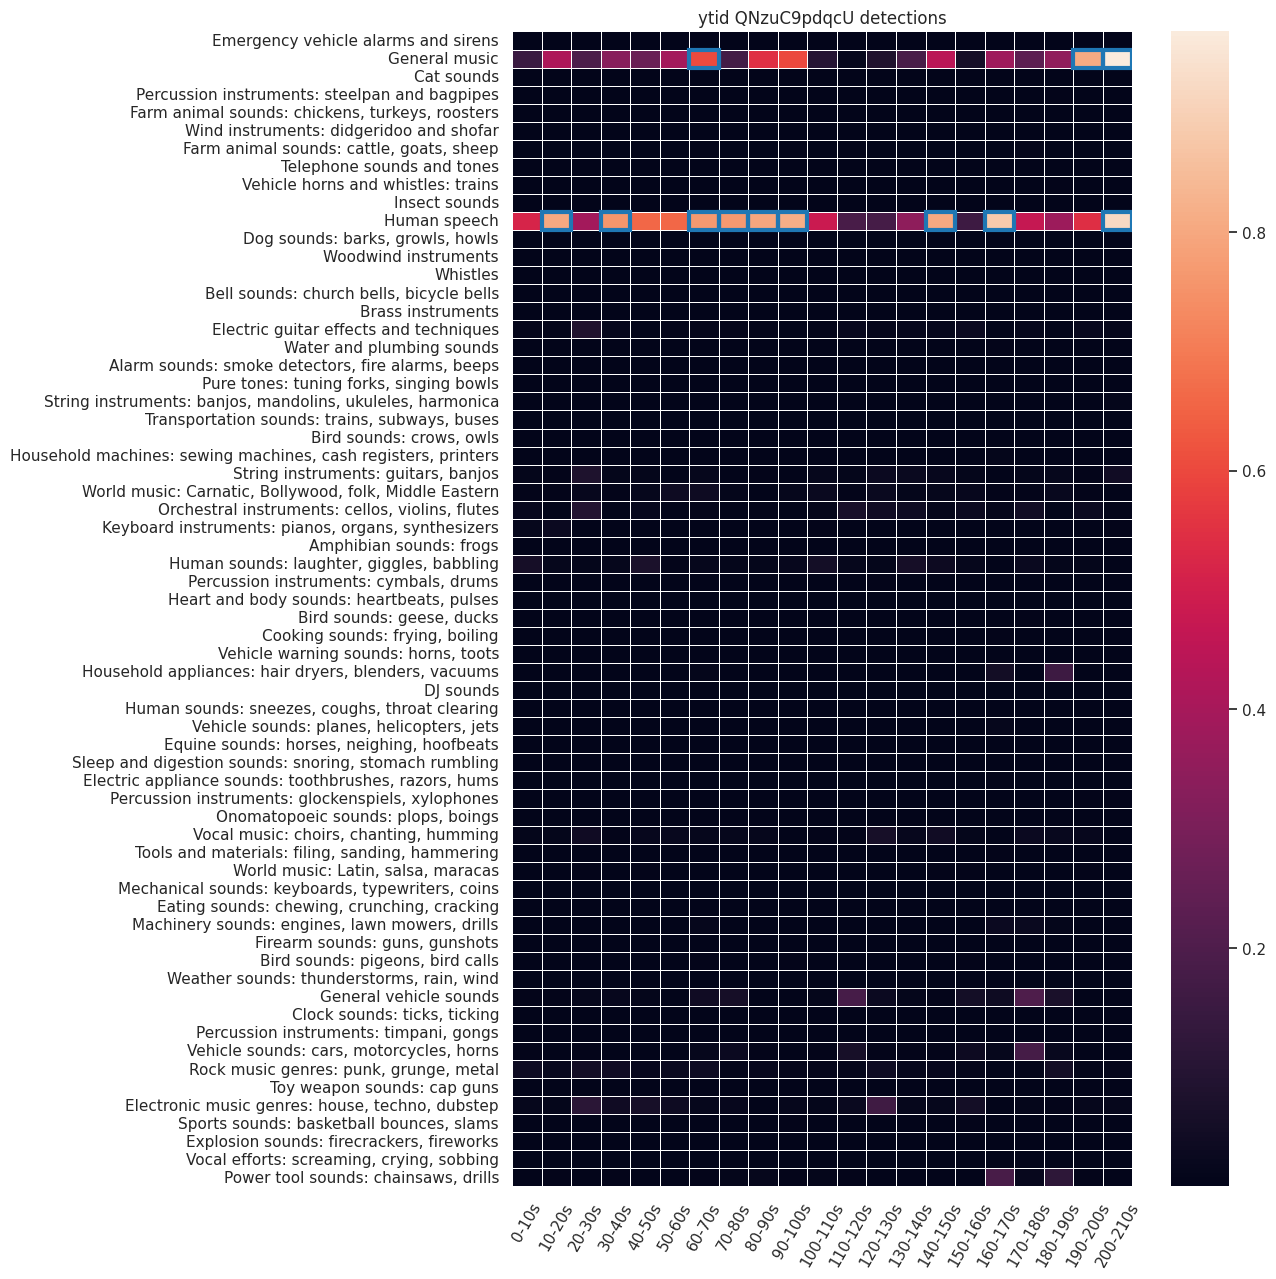

In [36]:
sns.set_palette("magma")

all_probs_rot = all_probs.T
all_preds_rot = all_preds.T

x_axis_labels = [f"{time_i*duration_for_embed}-{(time_i+1)*duration_for_embed}s" for time_i in range(all_probs_rot.shape[1])]
y_axis_labels = [model_order_to_group_name[x] for x in range(all_probs_rot.shape[0])]

sns.set(rc={'figure.figsize':(10, 15)})
ax = sns.heatmap(all_probs_rot, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

for x in range(all_preds_rot.shape[0]):
    for y in range(all_preds_rot.shape[1]):
        if all_preds_rot[x,y] == 1:
            ax.add_patch(Rectangle((y,x), 1, 1, fill=False, edgecolor="tab:blue", lw=3))
    
plt.xticks(rotation=60)
plt.title(f"ytid {ytid} detections")
plt.show()